# Convolutional Neural Networks: Application


实现一个非常简单的 卷积神经网络。 识别手势表示的数字。

使用keras实现


## 1 - 准备数据


In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


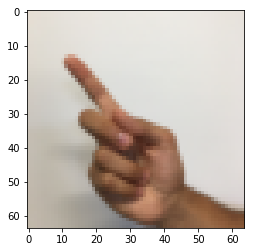

In [4]:
# Example of a picture
index = 8
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## 2 Keras Model


In [6]:

def create_model(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    
#     tf.set_random_seed(1)   
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer())
    
    # forward propagation
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z3, labels = Y))
    parameters = {'W1': W1, 'W2': W2}
    
    return X, Y, Z3, cost, parameters


In [18]:
# GRADED FUNCTION: HappyModel

from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization
from keras.layers import Activation, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Model


def create_model(input_shape):
    # 类似于tf的 placeholder
    X_input = Input(input_shape)
    
    # CONV: filter 5x5x3x8, s = 1, p = 2, same
    X = ZeroPadding2D(2)(X_input)
    X = Conv2D(8, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    
    # CONV2: filter 5x5x8x16, s = 1, p = 2, same
    X = ZeroPadding2D(2)(X)
    X = Conv2D(16, (5, 5), strides = (1, 1), name = 'conv10')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(6, activation='softmax', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model


# 不需要样本数量
model = create_model(X_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 68, 68, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 8)         608       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 8)         0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 32, 32, 8)         0         
__________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics = ["accuracy"])

In [32]:
model.fit(x=X_train, y=Y_train, epochs=10, batch_size=32)

Epoch 1/10
1080/1080 [==============================] - 0s 194us/step - loss: 8.4792e-04 - acc: 1.0000
Epoch 2/10
1080/1080 [==============================] - 0s 187us/step - loss: 0.0010 - acc: 1.0000
Epoch 3/10
1080/1080 [==============================] - 0s 182us/step - loss: 8.8312e-04 - acc: 1.0000
Epoch 4/10
1080/1080 [==============================] - 0s 181us/step - loss: 8.9880e-04 - acc: 1.0000
Epoch 5/10
1080/1080 [==============================] - 0s 180us/step - loss: 8.1025e-04 - acc: 1.0000
Epoch 6/10
1080/1080 [==============================] - 0s 180us/step - loss: 9.1263e-04 - acc: 1.0000
Epoch 7/10
1080/1080 [==============================] - 0s 182us/step - loss: 8.4185e-04 - acc: 1.0000
Epoch 8/10
1080/1080 [==============================] - 0s 180us/step - loss: 7.2139e-04 - acc: 1.0000
Epoch 9/10
1080/1080 [==============================] - 0s 180us/step - loss: 7.4343e-04 - acc: 1.0000
Epoch 10/10
1080/1080 [==============================] - 0s 180us/step - loss

In [33]:

preds = model.evaluate(x =X_test, y =Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

120/120 [==============================] - 0s 80us/step

Loss = 0.2140441805124283
Test Accuracy = 0.924999996026357


用了正则化方法Dropout之后， 同样的训练条件，从 62.5% 提升到 90.8%

再多训练10个epoch，可以达到 95.8333

再多训练10个epoch，可以达到 96.6%，相当于 120个测试错了4个。

其实训练的越久越不好。一种解释是 样本重复了很多遍，导致“机器”认为这个世界上大部分事物是这样的，导致了一种“认知偏差”，其实就是过拟合。

Dropout实际上是引入了一种噪声。


2018-03-08 15:09:54 更新：
使用GPU之后， 170us/step。  之前用CPU的时候是： 9ms/step， 速度提高了 50倍，还是相当可观的。 
但是不知道为啥，测试集上的评分不如以前高了。 最高为： 92.5%， 相当于120个错了9个。


In [38]:
predictions = model.predict(x=X_test)
predictions = np.argmax(predictions, axis=1)

In [45]:
# ix = np.nonzero(predictions - Y_test_orig[0])
# ix[0]
np.squeeze(np.asarray(np.where(predictions != Y_test_orig[0])))

array([ 46,  59,  86, 103])

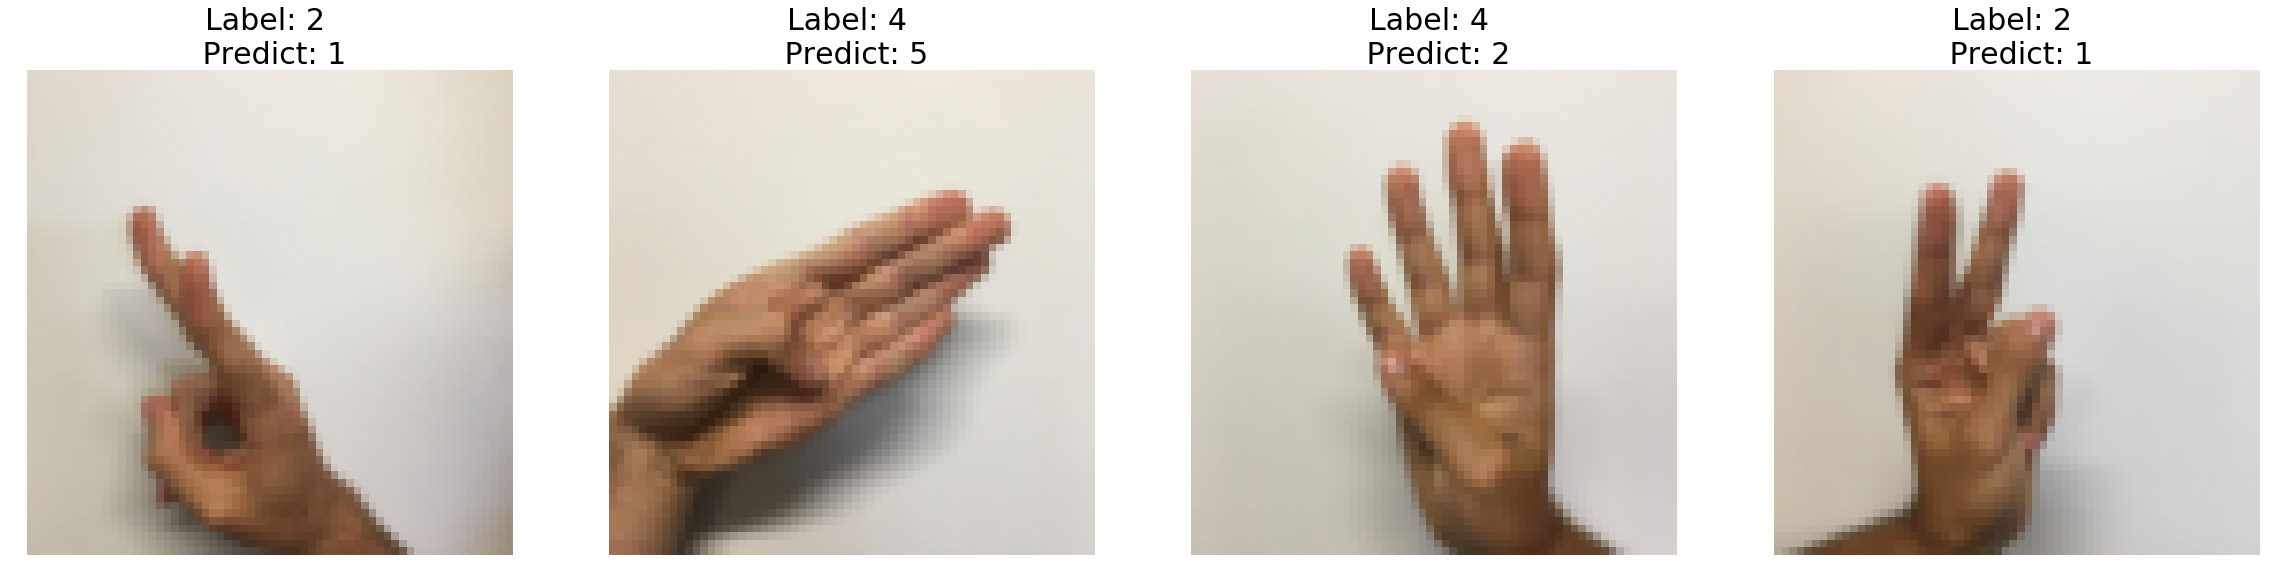

In [61]:
def print_mislabeled_images(images, labels, predictions):
    mislabeled_indices = np.squeeze(np.asarray(np.where(predictions != labels)))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices)
    for i in range(num_images):
        index = mislabeled_indices[i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[index])
        plt.axis('off')
        plt.title("Label: " + str(np.squeeze(labels[index]))
                  + " \n Predict: " + str(np.squeeze(predictions[index])), fontsize=30)

print_mislabeled_images(X_test_orig, Y_test_orig[0], predictions)

第一个识别有问题，没关系。第二个有难度； 但是后两个区分很明显啊，为什么无法识别？？

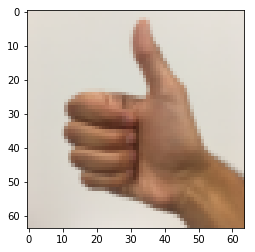

In [22]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)